# 简单因子回测测试

测试新的 Mark-to-Market 回测系统，使用简单的动量因子（20日收益率）


In [10]:
# 导入库和设置路径
import sys
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 设置 matplotlib 支持中文显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS', 'DejaVu Sans']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 添加项目根目录到路径
project_root = Path().resolve().parent.parent
sys.path.append(str(project_root))

# 重新加载模块（确保使用最新代码）
import importlib
if 'research.backtest.signals' in sys.modules:
    importlib.reload(sys.modules['research.backtest.signals'])
if 'research.backtest.portfolio_bt' in sys.modules:
    importlib.reload(sys.modules['research.backtest.portfolio_bt'])
if 'research.backtest.factor_test' in sys.modules:
    importlib.reload(sys.modules['research.backtest.factor_test'])

# 导入项目模块
from research.backtest.signals import normalize_factor, normalize_positions
from research.backtest.portfolio_bt import simulate_portfolio, calculate_metrics, load_costs_config, load_backtest_config, create_synthetic_benchmark
from research.backtest.factor_test import factor_returns_by_quantile

print("✓ 所有模块导入成功！")
print(f"项目根目录: {project_root}")


✓ 所有模块导入成功！
项目根目录: C:\Users\Chengyu Gong\Klpha\KlphaOriginal


## 步骤 1: 加载数据


In [11]:
# 加载数据
data_path = project_root / "data" / "processed" / "data.pkl"

print(f"加载数据: {data_path}")
with open(data_path, 'rb') as f:
    data = pickle.load(f)

print(f"\n数据包含的字段: {list(data.keys())}")
print(f"\n数据统计:")
for key, df in data.items():
    if isinstance(df, pd.DataFrame):
        print(f"  {key}: {df.shape[0]} 行 × {df.shape[1]} 列")
        print(f"    日期范围: {df.index.min()} 到 {df.index.max()}")

# 创建合成基准（等权重组合），消除幸存者偏差
print(f"\n创建合成基准（等权重组合）...")
synthetic_benchmark = create_synthetic_benchmark(data['close'])
print(f"  合成基准数据: {len(synthetic_benchmark)} 个交易日")
print(f"  日期范围: {synthetic_benchmark.index.min()} 到 {synthetic_benchmark.index.max()}")
print(f"  说明: 基于当前股票池构建等权重指数，确保基准和策略使用相同的股票池")


加载数据: C:\Users\Chengyu Gong\Klpha\KlphaOriginal\data\processed\data.pkl

数据包含的字段: ['close', 'open', 'high', 'low', 'volume']

数据统计:
  close: 2763 行 × 501 列
    日期范围: 2015-01-02 00:00:00-05:00 到 2025-12-26 00:00:00-05:00
  open: 2763 行 × 501 列
    日期范围: 2015-01-02 00:00:00-05:00 到 2025-12-26 00:00:00-05:00
  high: 2763 行 × 501 列
    日期范围: 2015-01-02 00:00:00-05:00 到 2025-12-26 00:00:00-05:00
  low: 2763 行 × 501 列
    日期范围: 2015-01-02 00:00:00-05:00 到 2025-12-26 00:00:00-05:00
  volume: 2763 行 × 501 列
    日期范围: 2015-01-02 00:00:00-05:00 到 2025-12-26 00:00:00-05:00

创建合成基准（等权重组合）...
  合成基准数据: 2762 个交易日
  日期范围: 2015-01-05 00:00:00-05:00 到 2025-12-26 00:00:00-05:00
  说明: 基于当前股票池构建等权重指数，确保基准和策略使用相同的股票池


## 步骤 2: 计算简单动量因子（20日收益率）


In [12]:
# 计算简单的动量因子：20日收益率
print("计算动量因子（20日收益率）...")

# 使用收盘价计算20日收益率
momentum_factor = data['close'].pct_change(20)

print(f"\n因子值统计:")
print(f"  形状: {momentum_factor.shape}")
print(f"  均值: {momentum_factor.mean().mean():.6f}")
print(f"  标准差: {momentum_factor.std().mean():.6f}")
print(f"  缺失值比例: {momentum_factor.isna().sum().sum() / momentum_factor.size * 100:.2f}%")

# 查看某个日期的因子值分布
sample_date = momentum_factor.index[100]
print(f"\n示例日期 {sample_date} 的因子值统计:")
sample_row = momentum_factor.loc[sample_date].dropna()
print(f"  有效股票数: {len(sample_row)}")
print(f"  最小值: {sample_row.min():.4f}")
print(f"  最大值: {sample_row.max():.4f}")
print(f"  中位数: {sample_row.median():.4f}")


计算动量因子（20日收益率）...

因子值统计:
  形状: (2763, 501)
  均值: 0.013595
  标准差: 0.085723
  缺失值比例: 4.25%

示例日期 2015-05-28 00:00:00-04:00 的因子值统计:
  有效股票数: 461
  最小值: -0.1807
  最大值: 0.2166
  中位数: 0.0135


## 步骤 3: 因子标准化和信号生成


In [13]:
# 处理缺失值
factor_clean = momentum_factor.fillna(0.0)

# 横截面标准化（使用 Z-score）
print("横截面标准化（Z-score）...")
factor_normalized = normalize_factor(factor_clean, method='zscore')
print(f"✓ 标准化完成")

# 注意：不要在这里做仓位归一化！
# 应该传入原始因子信号给 simulate_portfolio，让它内部处理滚动平均和归一化
# 这样 window_size 才能正确生效

# 生成交易信号（只做标准化，不做仓位归一化）
# simulate_portfolio 内部会处理滚动平均和仓位归一化
positions = factor_normalized

print(f"✓ 因子信号准备完成")
print(f"  信号形状: {positions.shape}")
print(f"  信号统计: {positions.sum(axis=1).describe()}")

# 注意：positions 现在不是归一化的仓位，而是因子信号
# simulate_portfolio 会内部处理滚动平均和归一化


横截面标准化（Z-score）...
✓ 标准化完成
✓ 因子信号准备完成
  信号形状: (2763, 501)
  信号统计: count    2.763000e+03
mean     1.102910e-15
std      2.676344e-14
min     -1.456613e-13
25%     -1.243450e-14
50%      0.000000e+00
75%      1.421085e-14
max      1.509903e-13
dtype: float64


## 步骤 4: 运行回测


In [14]:
# 加载配置
costs = load_costs_config()
backtest_config = load_backtest_config()

# 从配置文件读取 window_size
window_size = backtest_config.get('window_size', 1)
booksize = backtest_config.get('booksize', 1.0)
upper_bound = backtest_config.get('upper_bound', 0.1)

print(f"交易成本配置: {costs}")
print(f"回测配置:")
print(f"  window_size: {window_size}")
print(f"  booksize: {booksize}")
print(f"  upper_bound: {upper_bound}")

print("\n" + "=" * 60)
print(f"运行回测 (window_size={window_size})")
print("=" * 60)

# 运行回测（使用配置文件中的 window_size）
bt_results = simulate_portfolio(
    alpha=positions,
    prices=data['close'],
    volume=data.get('volume', data['close']),
    costs=costs,
    booksize=booksize,
    upper_bound=upper_bound,
    window_size=window_size
)

print(f"✓ 回测完成")
print(f"  回测天数: {len(bt_results)}")
print(f"  日期范围: {bt_results.index.min()} 到 {bt_results.index.max()}")

# 显示回测结果概览
print(f"\n回测结果概览:")
print(bt_results[['ret', 'ret_net', 'tvr', 'long_size']].describe())


交易成本配置: {'commission': 0.001, 'slippage': 0.0005, 'total_cost': 0.0015, 'fixed_commission': 0.0, 'min_commission': 0.0}
回测配置:
  window_size: 14
  booksize: 1.0
  upper_bound: 0.1

运行回测 (window_size=14)
✓ 回测完成
  回测天数: 2763
  日期范围: 2015-01-02 00:00:00-05:00 到 2025-12-26 00:00:00-05:00

回测结果概览:
               ret      ret_net          tvr    long_size
count  2763.000000  2763.000000  2763.000000  2763.000000
mean      0.000679     0.000548     0.087213     0.992761
std       0.011366     0.011367     0.022430     0.084786
min      -0.088211    -0.088341     0.000000     0.000000
25%      -0.004699    -0.004838     0.079660     1.000000
50%       0.001045     0.000915     0.087095     1.000000
75%       0.006683     0.006554     0.094802     1.000000
max       0.064062     0.063943     1.000000     1.000000


## 步骤 5: 计算性能指标


In [15]:
# 计算性能指标（使用费后收益率，包含 CAPM 指标）
# 使用合成基准（等权重组合）消除幸存者偏差
metrics = calculate_metrics(
    bt_results['ret_net'], 
    risk_free_rate=0.0,
    benchmark_returns=synthetic_benchmark
)

print("=" * 60)
print("回测性能指标")
print("=" * 60)
print(f"算术年化收益率: {metrics['annual_return_arithmetic']*100:.2f}%")
print(f"几何年化收益率: {metrics['annual_return_geometric']*100:.2f}%")
print(f"年化波动率: {metrics['annual_volatility']*100:.2f}%")
print(f"夏普比率: {metrics['sharpe_ratio']:.4f}")
print(f"累计收益率: {metrics['cumulative_return']*100:.2f}%")
print(f"最大回撤: {metrics['max_drawdown']*100:.2f}%")
print(f"最大回撤持续时间: {metrics['max_drawdown_duration']} 天")
print(f"胜率: {metrics['win_rate']*100:.2f}%")
print(f"盈亏比: {metrics['profit_loss_ratio']:.4f}")
print(f"总交易天数: {metrics['total_trades']}")
print(f"盈利天数: {metrics['positive_trades']}")
print(f"亏损天数: {metrics['negative_trades']}")

# CAPM 指标（相对合成基准 - 等权重组合）
if not pd.isna(metrics['alpha']):
    print("\n" + "-" * 60)
    print("CAPM 指标 (相对合成基准 - 等权重组合)")
    print("-" * 60)
    print(f"Alpha (年化): {metrics['alpha']*100:.2f}%")
    print(f"Beta: {metrics['beta']:.4f}")
    print(f"R-Squared: {metrics['r_squared']:.4f}")
    print("\n说明: 合成基准基于当前股票池构建，消除了幸存者偏差")
else:
    print("\n" + "-" * 60)
    print("CAPM 指标: 未计算（缺少基准数据）")
    print("-" * 60)

print("=" * 60)

# 平均换手率
avg_tvr = bt_results['tvr'].mean()
print(f"\n平均换手率: {avg_tvr*100:.2f}%")


回测性能指标
算术年化收益率: 13.82%
几何年化收益率: 12.95%
年化波动率: 18.04%
夏普比率: 0.7179
累计收益率: 280.18%
最大回撤: -31.50%
最大回撤持续时间: 376 天
胜率: 54.90%
盈亏比: 0.9288
总交易天数: 2763
盈利天数: 1517
亏损天数: 1226

------------------------------------------------------------
CAPM 指标 (相对合成基准 - 等权重组合)
------------------------------------------------------------
Alpha (年化): -0.98%
Beta: 0.8915
R-Squared: 0.8209

说明: 合成基准基于当前股票池构建，消除了幸存者偏差

平均换手率: 8.72%


## 步骤 6: 可视化结果


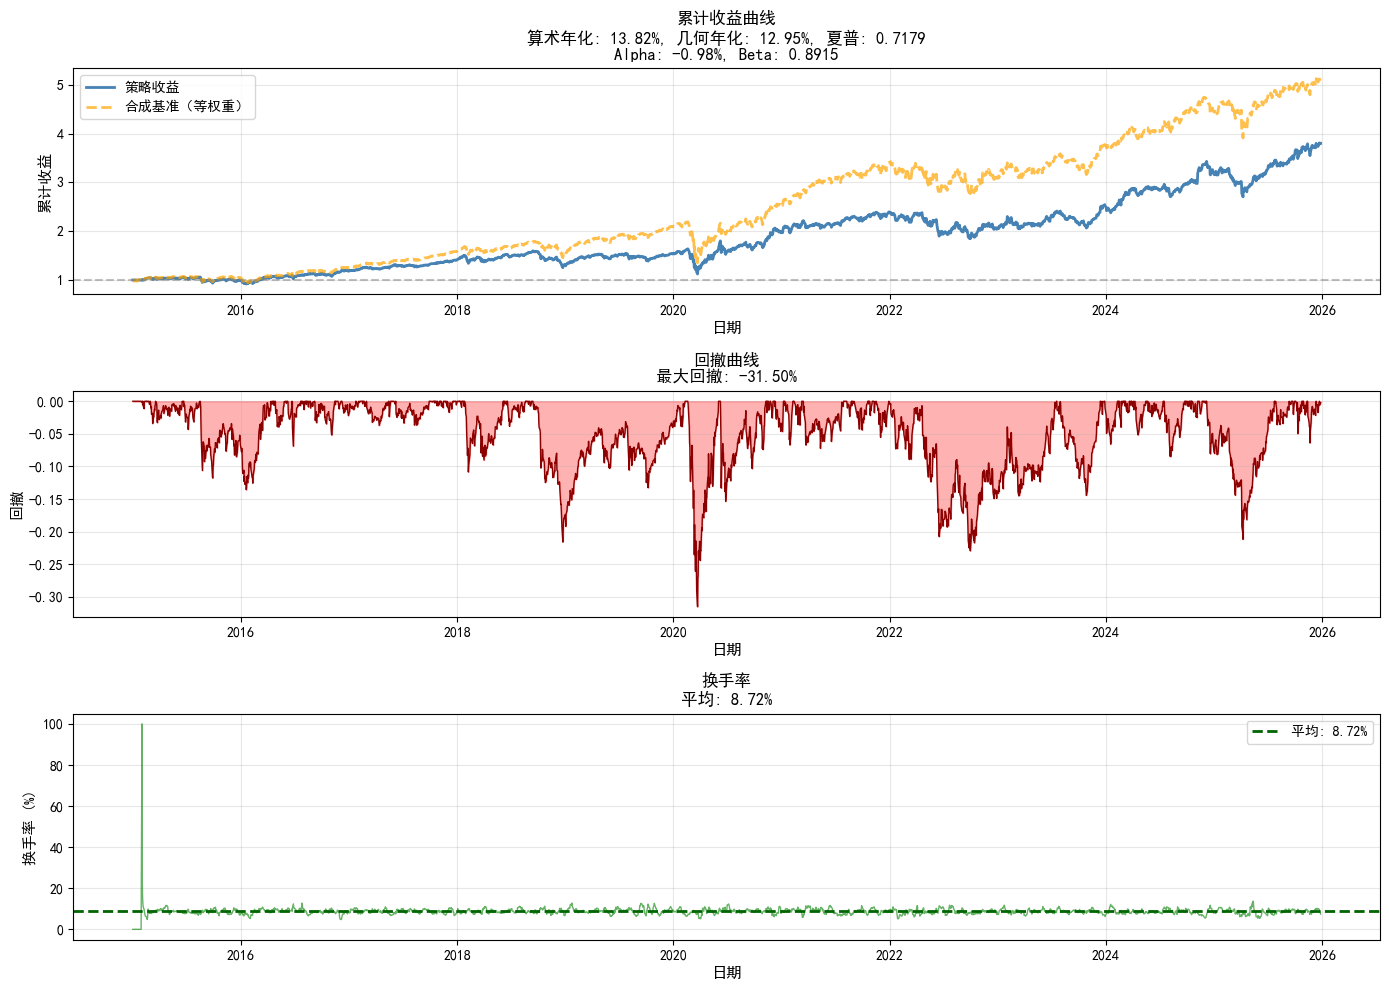

In [16]:
# 绘制累计收益曲线
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# 1. 累计收益曲线
cumulative_ret = (1 + bt_results['ret_net']).cumprod()
axes[0].plot(cumulative_ret.index, cumulative_ret.values, linewidth=2, color='steelblue', label='策略收益')

# 绘制合成基准收益曲线（等权重组合）
# 对齐日期
common_dates = cumulative_ret.index.intersection(synthetic_benchmark.index)
if len(common_dates) > 0:
    benchmark_cumulative = (1 + synthetic_benchmark.loc[common_dates]).cumprod()
    axes[0].plot(benchmark_cumulative.index, benchmark_cumulative.values, 
                 linewidth=2, color='orange', linestyle='--', alpha=0.7, label='合成基准（等权重）')
    axes[0].legend(fontsize=10)

title = f'累计收益曲线\n算术年化: {metrics["annual_return_arithmetic"]*100:.2f}%, 几何年化: {metrics["annual_return_geometric"]*100:.2f}%, 夏普: {metrics["sharpe_ratio"]:.4f}'
if not pd.isna(metrics['alpha']):
    title += f'\nAlpha: {metrics["alpha"]*100:.2f}%, Beta: {metrics["beta"]:.4f}'
axes[0].set_title(title, fontsize=12, fontweight='bold')
axes[0].set_xlabel('日期', fontsize=11)
axes[0].set_ylabel('累计收益', fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].axhline(1, color='gray', linestyle='--', alpha=0.5)

# 2. 回撤曲线
cumulative = (1 + bt_results['ret_net']).cumprod()
running_max = cumulative.expanding().max()
drawdown = (cumulative - running_max) / running_max
axes[1].fill_between(drawdown.index, drawdown.values, 0, color='red', alpha=0.3)
axes[1].plot(drawdown.index, drawdown.values, linewidth=1, color='darkred')
axes[1].set_title(f'回撤曲线\n最大回撤: {metrics["max_drawdown"]*100:.2f}%', 
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('日期', fontsize=11)
axes[1].set_ylabel('回撤', fontsize=11)
axes[1].grid(True, alpha=0.3)

# 3. 换手率
axes[2].plot(bt_results['tvr'].index, bt_results['tvr'].values * 100, linewidth=1, color='green', alpha=0.6)
axes[2].axhline(avg_tvr * 100, color='darkgreen', linestyle='--', linewidth=2, label=f'平均: {avg_tvr*100:.2f}%')
axes[2].set_title(f'换手率\n平均: {avg_tvr*100:.2f}%', 
                  fontsize=12, fontweight='bold')
axes[2].set_xlabel('日期', fontsize=11)
axes[2].set_ylabel('换手率 (%)', fontsize=11)
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 步骤 7: 因子分位数分析


In [17]:
# 因子分位数分析（10组）
print("计算因子分位数收益（10组）...")

# 使用 factor_returns_by_quantile 计算分位数收益
quantile_returns = factor_returns_by_quantile(
    factor_values=momentum_factor,
    forward_returns=data['close'].pct_change(),
    n_quantiles=10
)

# 计算年化收益（每日收益 * 252）
quantile_annual_returns = quantile_returns.mean() * 252

# 计算多空收益（最高分位 - 最低分位）
long_short_return = quantile_annual_returns.iloc[-1] - quantile_annual_returns.iloc[0]

print("\n" + "=" * 60)
print("因子分位数年化收益（10组）")
print("=" * 60)
for q in range(1, 11):
    if q in quantile_annual_returns.index:
        print(f"Q{q}: {quantile_annual_returns[q]*100:.2f}%")

print(f"\n多空收益 (Q10-Q1): {long_short_return*100:.2f}%")
print("=" * 60)


计算因子分位数收益（10组）...

因子分位数年化收益（10组）
Q1: -143.54%
Q2: -66.96%
Q3: -35.02%
Q4: -11.92%
Q5: 9.93%
Q6: 27.48%
Q7: 47.05%
Q8: 68.15%
Q9: 98.01%
Q10: 175.82%

多空收益 (Q10-Q1): 319.36%


## 步骤 8: 分位数分析可视化


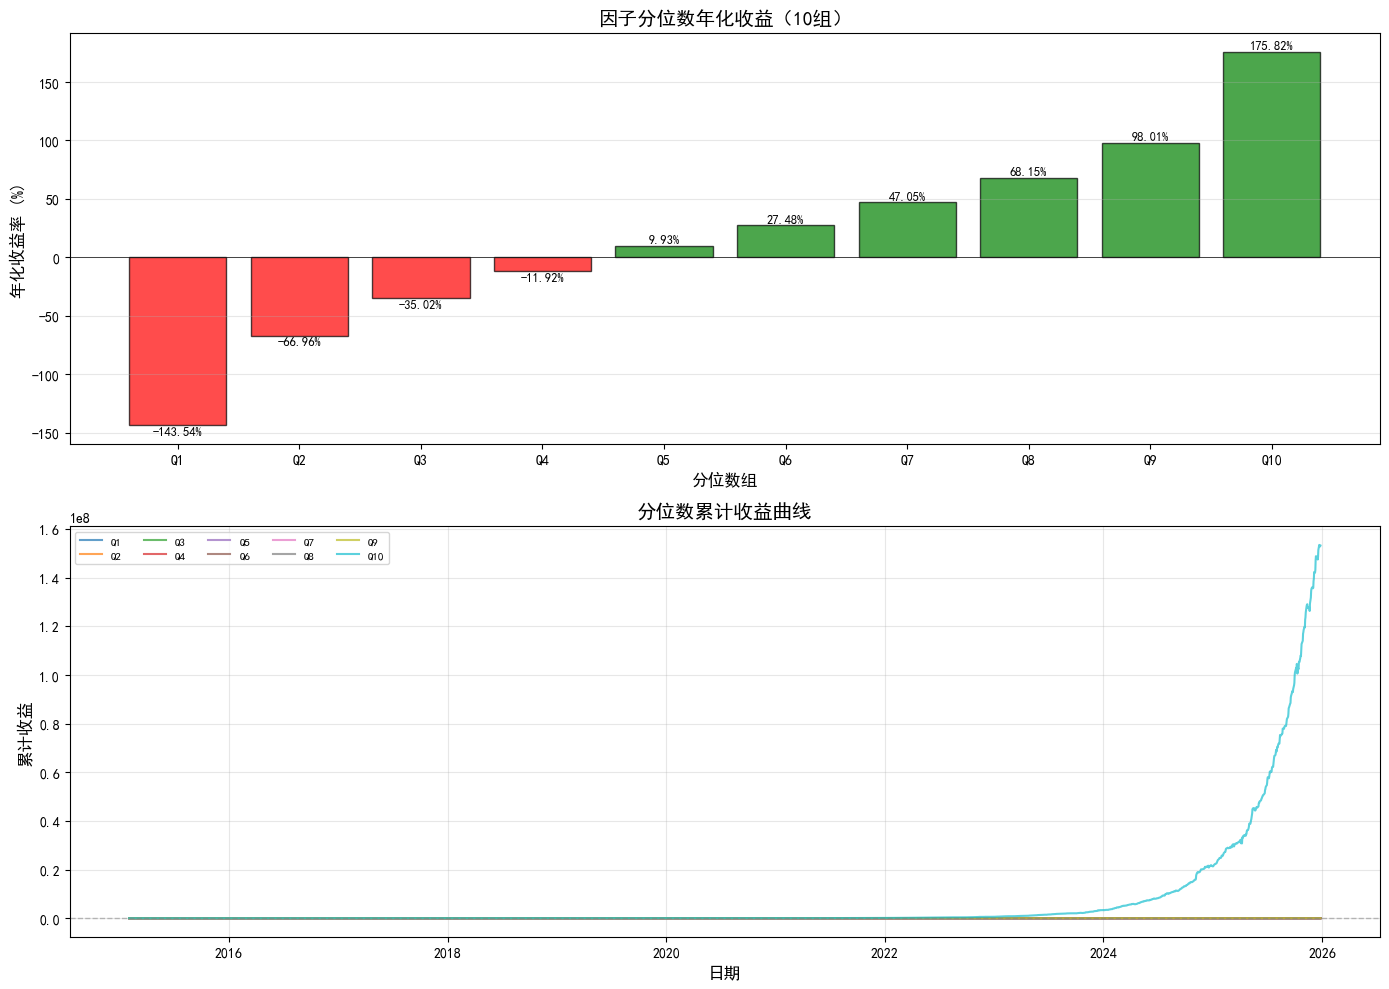


分位数收益统计:
  最高分位 (Q10) 年化收益: 175.82%
  最低分位 (Q1) 年化收益: -143.54%
  多空收益 (Q10-Q1): 319.36%


In [18]:
# 绘制分位数分析图
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# 1. 分位数年化收益柱状图
quantile_labels = [f'Q{q}' for q in range(1, 11)]
quantile_values = [quantile_annual_returns[q]*100 if q in quantile_annual_returns.index else 0 for q in range(1, 11)]

colors = ['red' if v < 0 else 'green' for v in quantile_values]
axes[0].bar(quantile_labels, quantile_values, color=colors, alpha=0.7, edgecolor='black')
axes[0].axhline(0, color='black', linestyle='-', linewidth=0.5)
axes[0].set_title('因子分位数年化收益（10组）', fontsize=14, fontweight='bold')
axes[0].set_xlabel('分位数组', fontsize=12)
axes[0].set_ylabel('年化收益率 (%)', fontsize=12)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_xticks(range(10))
axes[0].set_xticklabels(quantile_labels)

# 添加数值标签
for i, (label, value) in enumerate(zip(quantile_labels, quantile_values)):
    axes[0].text(i, value + (0.5 if value >= 0 else -0.5), f'{value:.2f}%', 
                ha='center', va='bottom' if value >= 0 else 'top', fontsize=9)

# 2. 分位数累计收益曲线
cumulative_quantile_returns = (1 + quantile_returns).cumprod()
for q in range(1, 11):
    if q in cumulative_quantile_returns.columns:
        axes[1].plot(cumulative_quantile_returns.index, 
                    cumulative_quantile_returns[q].values, 
                    label=f'Q{q}', linewidth=1.5, alpha=0.7)

axes[1].axhline(1, color='gray', linestyle='--', linewidth=1, alpha=0.5)
axes[1].set_title('分位数累计收益曲线', fontsize=14, fontweight='bold')
axes[1].set_xlabel('日期', fontsize=12)
axes[1].set_ylabel('累计收益', fontsize=12)
axes[1].legend(loc='best', ncol=5, fontsize=8)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 打印统计信息
print(f"\n分位数收益统计:")
print(f"  最高分位 (Q10) 年化收益: {quantile_annual_returns.iloc[-1]*100:.2f}%")
print(f"  最低分位 (Q1) 年化收益: {quantile_annual_returns.iloc[0]*100:.2f}%")
print(f"  多空收益 (Q10-Q1): {long_short_return*100:.2f}%")
